## Goal

This module will dive into human-in-the-loop, which builds on memory and allows users to interact directly with graphs in various ways.

### Learning Steps:
- `Breakpoints`
- `Dynamic Breakpoints`

#### imports

In [1]:
from typing import Annotated, TypedDict
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import START, END, StateGraph, MessageGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.errors import NodeInterrupt

from IPython.display import display, Image

In [28]:
load_dotenv()

True

### tool functions

In [2]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


In [3]:
tools = [multiply, add, divide]

In [4]:
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

In [5]:
llm_with_tools = llm.bind_tools(tools)

In [6]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [7]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

'''
Pause execution right before running the node(s) named 'tools'.
This is typically used in agentic or tool-using workflows — where the LLM decides what tool to call, and you (the developer) 
want a chance to inspect or approve the action before continuing.
'''
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

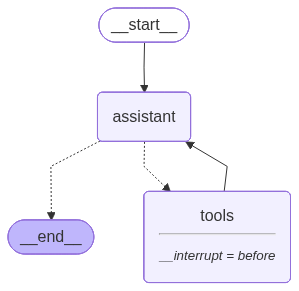

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

#### Check the result

In [9]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

<think>
Okay, the user wants to multiply 2 and 3. Let me check the available functions. There's a multiply function that takes two integers, a and b. The parameters are required, so I need to make sure both are included. The arguments should be {"a": 2, "b": 3}. I'll call the multiply function with these values.
</think>
Tool Calls:
  multiply (chatcmpl-tool-bd288216a151d095)
 Call ID: chatcmpl-tool-bd288216a151d095
  Args:
    a: 2
    b: 3


In [10]:
state = graph.get_state(thread)
state.next

('tools',)

In [11]:
'''
For clarity, LangGraph will re-emit the current state, which contains the AIMessage with tool call.
And then it will proceed to execute the following steps in the graph, which start with the tool node.
We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.
'''

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user wants to multiply 2 and 3. Let me check the available functions. There's a multiply function that takes two integers, a and b. The parameters are required, so I need to make sure both are included. The arguments should be {"a": 2, "b": 3}. I'll call the multiply function with these values.
</think>
Tool Calls:
  multiply (chatcmpl-tool-bd288216a151d095)
 Call ID: chatcmpl-tool-bd288216a151d095
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

<think>
Okay, the user asked to multiply 2 and 3. I used the multiply function with a=2 and b=3. The result is 6. I should present the answer clearly. Let me check if there's anything else needed. The user might just want the product, so a straightforward response would be best.

Answer: 6


#### Lets bring the Human-in-the-Loop - All together

In [12]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

<think>
Okay, the user wants me to multiply 2 and 3. Let me check the available functions. There's a multiply function that takes two integers, a and b. The parameters are required, so I need to make sure both are included. The function's description says it multiplies them, which is exactly what the user is asking for. I don't see any other functions that would be relevant here. So I should call the multiply function with a=2 and b=3. The result should be 6. I need to format the tool call correctly in JSON inside the XML tags.
</think>
Tool Calls:
  multiply (chatcmpl-tool-af7dc48d39ec5449)
 Call ID: chatcmpl-tool-af7dc48d39ec5449
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================

<think>
Okay, the user wants me to multiply 2 and 3. Let me check the a

#### Get state history

In [13]:
all_states = [s for s in graph.get_state_history(thread)]

In [14]:
len(all_states)

5

In [15]:
to_replay = all_states[-2]

In [16]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='1d81f70f-4dc9-49ba-b53e-b920b8eedf2b')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10b3ed-9820-60cc-8000-964a555291ac'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-16T13:53:19.024960+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10b3ed-981d-6cba-bfff-b092b4c71dc7'}}, tasks=(PregelTask(id='03ac53d6-2294-35b9-5ae4-a88bdd963e76', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content="<think>\nOkay, the user wants me to multiply 2 and 3. Let me check the available functions. There's a multiply function that takes two integers, a and b. The parameters are required, so I need to make sure both are included. The function's description says it mul

In [17]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='1d81f70f-4dc9-49ba-b53e-b920b8eedf2b')]}

In [18]:
to_replay.metadata

{'source': 'loop', 'step': 0, 'parents': {}}

In [19]:
to_replay.next

('assistant',)

In [20]:
to_replay.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10b3ed-9820-60cc-8000-964a555291ac'}}

In [21]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

<think>
Okay, the user wants me to multiply 2 and 3. Let me check the available functions. There's a multiply function that takes two integers, a and b. The parameters are required, so I need to make sure both are included. The function's description says it multiplies them, which is exactly what the user is asking for. So I should call the multiply function with a=2 and b=3. I don't need to use any other functions here since the request is straightforward. Let me structure the tool call correctly in JSON as specified.
</think>
Tool Calls:
  multiply (chatcmpl-tool-992ab3fe65ddb73b)
 Call ID: chatcmpl-tool-992ab3fe65ddb73b
  Args:
    a: 2
    b: 3


#### Real life example

In [23]:
import operator

from langchain_community.document_loaders import WikipediaLoader
from langchain_tavily import TavilySearch

#### Declaring state
- Either use `operator.add` or `add_messages`

In [37]:
# class State(TypedDict):
#     question: str
#     answer: str
#     context: Annotated[list, operator.add]

In [24]:
# using add_messages
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, add_messages]

In [25]:
def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs["results"]
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

#### Building Graph

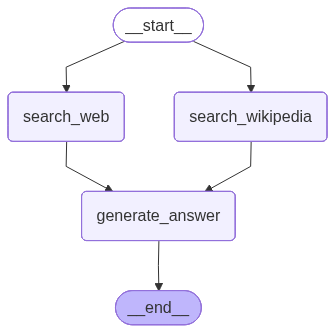

In [26]:
# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"<think>\nOkay, I need to figure out how Nvidia performed in their Q2 2024 earnings based on the provided documents. Let me start by going through each document carefully.\n\nFirst, the Axios article says that Nvidia's revenue soared to a record $30 billion in their latest fiscal quarter, which is Q2 2024. That's a significant number. They mention that this was driven by demand for AI products and services. Also, they beat expectations, which is a positive sign. The article also points out that Nvidia is a key barometer for AI interest globally, so their performance reflects growing AI investments. However, there are questions about whether companies will see returns on their AI investments. But the company's executive argues that AI infrastructure saves costs in the long run. An analyst even expects data center revenue to jump to over $200 billion this year from $47.5 billion last year. That's a huge growth projection.\n\nNext, the Road to Autonomy Index document mentions that Nvidia'